In [2]:
! pip3 install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
! pip3 install transformers
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import lucem_illud_2020
from google.colab import drive

  Cloning git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git to /tmp/pip-req-build-mpcmfk0l
  Running command git clone -q git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git /tmp/pip-req-build-mpcmfk0l
     |████████████████████████████████| 5.5MB 2.5MB/s 
     |████████████████████████████████| 122kB 30.3MB/s 
     |████████████████████████████████| 460kB 29.1MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 32.8MB 90kB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 450kB 42.3MB/s 
  Created wheel for lucem-illud-2020: filename=lucem_illud_2020-8.0.1-cp36-none-any.whl size=35129 sha256=f759c5cb7b3b332916b60fdde7562d4354aa5a34e87811d291d489ad7ee8606a
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0hl3fxq/wheels/a8/16/91/3c63788e494d360378317fe5ec9f4972f661844af8ae8c26f0
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-non

In [3]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [15]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
gpu = torch.cuda.is_available()

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [18]:
device

device(type='cuda')

In [4]:
import pandas
DATA_DIR = "/content/drive/My Drive/Colab Notebooks/"
file = DATA_DIR + "Train.csv"
f = open(file)
df = pandas.read_csv(f)
df.head


<bound method NDFrame.head of                                                     text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]>

In [0]:
sentences = df.text.values
labels = df.label.values

In [0]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'i', 'grew', 'up', '(', 'b', '.', '1965', ')', 'watching', 'and', 'loving', 'the', 'thunder', '##birds', '.', 'all', 'my', 'mates', 'at', 'school', 'watched', '.', 'we', 'played', '"', 'thunder', '##birds', '"', 'before', 'school', ',', 'during', 'lunch', 'and', 'after', 'school', '.', 'we', 'all', 'wanted', 'to', 'be', 'virgil', 'or', 'scott', '.', 'no', 'one', 'wanted', 'to', 'be', 'alan', '.', 'counting', 'down', 'from', '5', 'became', 'an', 'art', 'form', '.', 'i', 'took', 'my', 'children', 'to', 'see', 'the', 'movie', 'hoping', 'they', 'would', 'get', 'a', 'glimpse', 'of', 'what', 'i', 'loved', 'as', 'a', 'child', '.', 'how', 'bitterly', 'disappointing', '.', 'the', 'only', 'high', 'point', 'was', 'the', 'snap', '##py', 'theme', 'tune', '.', 'not', 'that', 'it', 'could', 'compare', 'with', 'the', 'original', 'score', 'of', 'the', 'thunder', '##birds', '.', 'thankfully', 'early', 'saturday', 'mornings', 'one', 'television', 'channel', 'still'

In [0]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

train_inputs, validation_inputs, train_labels, validation_labels= train_test_split(input_ids, labels,
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
batch_size = 32
no_labels = len(np.unique(labels))

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_lstm = model_lstm.fit(train_inputs, train_labels,
                              epochs=10,batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
36000/36000 [==============================] - 465s 13ms/step - loss: 0.5037 - accuracy: 0.7486
Epoch 2/10
36000/36000 [==============================] - 447s 12ms/step - loss: 0.3199 - accuracy: 0.8712
Epoch 3/10
36000/36000 [==============================] - 433s 12ms/step - loss: 0.2317 - accuracy: 0.9132
Epoch 4/10
36000/36000 [==============================] - 447s 12ms/step - loss: 0.1741 - accuracy: 0.9370
Epoch 5/10
36000/36000 [==============================] - 448s 12ms/step - loss: 0.1244 - accuracy: 0.9566
Epoch 6/10
36000/36000 [==============================] - 452s 13ms/step - loss: 0.0915 - accuracy: 0.9694
Epoch 7/10
36000/36000 [==============================] - 451s 13ms/step - loss: 0.0650 - accuracy: 0.9796
Epoch 8/10
36000/36000 [==============================] - 451s 13ms/step - loss: 0.0620 - accuracy: 0.9794
Epoch 9/10
36000/36000 [==============================] - 451s 13ms/step - loss: 0.0383 - accuracy: 0.9890
Epoch 10/10
36000/36000 [============

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [28]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [29]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [35]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')


======== Epoch 1 / 4 ========
Training...

======== Epoch 2 / 4 ========
Training...

======== Epoch 3 / 4 ========
Training...

======== Epoch 4 / 4 ========
Training...


In [0]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" )
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [37]:
import random


# # This training code is based on the `run_glue.py` script here:
# # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# # Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# # Store the average loss after each epoch so we can plot them.
loss_values = []

# # For each epoch...
for epoch_i in range(0, epochs):
  
    
#     # ========================================
#     #               Training
#     # ========================================
    
#     # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    model.cuda()

#     # Measure how long the training epoch takes.
    t0 = time.time()

#     # Reset the total loss for this epoch.
    total_loss = 0

#     # Put the model into training mode. Don't be mislead--the call to 
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

#     # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
#             # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader. 
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass. PyTorch doesn't do this automatically because 
#         # accumulating the gradients is "convenient while training RNNs". 
#         # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

#         # Perform a forward pass (evaluate the model on this training batch).
#         # This will return the loss (rather than the model output) because we
#         # have provided the `labels`.
#         # The documentation for this `model` function is here: 
#         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
#         # The call to `model` always returns a tuple, so we need to pull the 
#         # loss value out of the tuple.
        loss = outputs[0]

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value 
#         # from the tensor.
        total_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
        loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient.
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
        optimizer.step()

#         # Update the learning rate.
        scheduler.step()

#     # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
#     # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
    model.eval()

#     # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

#     # Evaluate data for one epoch
    for batch in validation_dataloader:
        
#         # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
#         # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up validation
        with torch.no_grad():        

#             # Forward pass, calculate logit predictions.
#             # This will return the logits rather than the loss because we have
#             # not provided labels.
#             # token_type_ids is the same as the "segment ids", which 
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             # The documentation for this `model` function is here: 
#             # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
#         # Get the "logits" output by the model. The "logits" are the output
#         # values prior to applying an activation function like the softmax.
        logits = outputs[0]

#         # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
#         # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
#         # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

#         # Track the number of batches
        nb_eval_steps += 1

#     # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,125.    Elapsed: 0:00:53.
  Batch    80  of  1,125.    Elapsed: 0:01:46.
  Batch   120  of  1,125.    Elapsed: 0:02:39.
  Batch   160  of  1,125.    Elapsed: 0:03:31.
  Batch   200  of  1,125.    Elapsed: 0:04:24.
  Batch   240  of  1,125.    Elapsed: 0:05:16.
  Batch   280  of  1,125.    Elapsed: 0:06:09.
  Batch   320  of  1,125.    Elapsed: 0:07:02.
  Batch   360  of  1,125.    Elapsed: 0:07:54.
  Batch   400  of  1,125.    Elapsed: 0:08:47.
  Batch   440  of  1,125.    Elapsed: 0:09:39.
  Batch   480  of  1,125.    Elapsed: 0:10:32.
  Batch   520  of  1,125.    Elapsed: 0:11:25.
  Batch   560  of  1,125.    Elapsed: 0:12:17.
  Batch   600  of  1,125.    Elapsed: 0:13:10.
  Batch   640  of  1,125.    Elapsed: 0:14:02.
  Batch   680  of  1,125.    Elapsed: 0:14:55.
  Batch   720  of  1,125.    Elapsed: 0:15:48.
  Batch   760  of  1,125.    Elapsed: 0:16:40.
  Batch   800  of  1,125.    Elapsed: 0:17:33.
  Batch   840  of

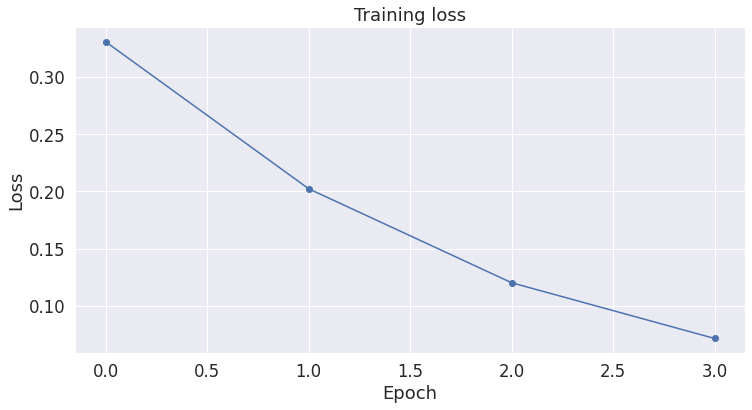

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# # Use plot styling from seaborn.
sns.set(style='darkgrid')

# # Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
plt.plot(loss_values, 'b-o')

# # Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
#model_to_save = model.module if hasattr(model, 'module') else model
model.save_pretrained('/content/drive/My Drive/Colab Notebooks/')


In [14]:
#model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/Colab Notebooks/content', num_labels=2)
!cd drive
!ls

drive  sample_data


In [146]:
#model = BertForSequenceClassification.from_pretrained("/content/", num_labels=2)

import pandas as pd

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Valid.csv", header = None, names=['text', 'label'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values 
labels = df.label.values
b = []
for each in labels:
  b.append(int(each,36))


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
  if len(sent) >= 512:
    sent = sent[:512]
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    input_ids.append(encoded_sent)
  else:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    input_ids.append(encoded_sent)


# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(b)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 5,001



In [147]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,001 test sentences...
    DONE.


In [148]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(b[1:]), len(df.label), (sum(b[1:]) / len(df.label) * 100.0)))

Positive samples: 2514 of 5001 (50.27%)


In [149]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [150]:
matthews_set

[0.8149569085627455,
 0.7490196078431373,
 0.7481900559272088,
 0.8126375006351424,
 0.938872452190116,
 0.8246211251235321,
 0.8096598849105344,
 0.7568627450980392,
 0.8749672939989046,
 0.6813969328454993,
 0.7294955398698875,
 0.6880212116344248,
 0.7568627450980392,
 0.8126375006351424,
 0.6070347255016324,
 0.746031746031746,
 0.7021819180245404,
 0.7568627450980392,
 0.873015873015873,
 0.7530836820370708,
 0.6255774501577784,
 0.9379228369755696,
 0.873015873015873,
 0.7021819180245404,
 0.5726562866782,
 0.938872452190116,
 0.6235294117647059,
 0.7568627450980392,
 0.8075728530872482,
 0.8096598849105344,
 0.8140915784106943,
 0.7410010097502685,
 0.8823529411764706,
 0.6813969328454993,
 0.7481900559272088,
 0.8749672939989046,
 0.6888467201936644,
 0.8823529411764706,
 0.598254541756288,
 0.7530836820370708,
 0.7410010097502685,
 0.5601675975251952,
 0.7410010097502685,
 0.8704453441295547,
 0.731126155013931,
 0.938872452190116,
 0.6888467201936644,
 0.7895918772038132,
 0.

In [151]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.768


In [0]:
output_dir = '/content/drive/My Drive/'
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)

In [0]:
from transformers import BertModel

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [158]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [197]:
text = df.text
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[:10])

[['[CLS]', 'text', '[SEP]'], ['[CLS]', 'it', "'", 's', 'been', 'about', '14', 'years', 'since', 'sharon', 'stone', 'awarded', 'viewers', 'a', 'leg', '-', 'crossing', 'that', 'twisted', 'many', 'people', "'", 's', 'minds', '.', 'and', 'now', ',', 'god', 'knows', 'why', ',', 'she', "'", 's', 'in', 'the', 'game', 'again', '.', '"', 'basic', 'instinct', '2', '"', 'is', 'the', 'sequel', 'to', 'the', 'smash', '-', 'hit', 'erotic', '##a', '"', 'basic', 'instinct', '"', 'featuring', 'a', 'sexy', 'stone', 'and', 'a', 'vulnerable', 'michael', 'douglas', '.', 'however', ',', 'fans', 'of', 'the', 'original', 'might', 'not', 'even', 'get', 'close', 'to', 'this', 'one', ',', 'since', '"', 'instinct', '2', '"', 'is', 'painful', 'film', '-', 'making', ',', 'as', 'the', 'med', '##io', '##cre', 'director', 'michael', 'cat', '##on', '-', 'jones', 'assassinate', '##s', 'the', 'legacy', 'of', 'the', 'first', 'film', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'the', 'plot', 'of', 'the', 'movie', 'starts

In [159]:
list(tokenizer.vocab.keys())[6000:6030]

['peninsula',
 'adults',
 'novels',
 'emerged',
 'vienna',
 'metro',
 'debuted',
 'shoes',
 'tamil',
 'songwriter',
 'meets',
 'prove',
 'beating',
 'instance',
 'heaven',
 'scared',
 'sending',
 'marks',
 'artistic',
 'passage',
 'superior',
 '03',
 'significantly',
 'shopping',
 '##tive',
 'retained',
 '##izing',
 'malaysia',
 'technique',
 'cheeks']

In [0]:
texts = []
for each in df['text'].values:
  marked_text = "[CLS] " + each + " [SEP]"
  texts.append(marked_text)
  
tokenized_text = [tokenizer.tokenize(marked_text) for marked_text in texts]

indexed_tokens = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_text]




In [10]:
for tup,token in zip(tokenized_text[1], indexed_tokens[1]):
  print(tup,token)

[CLS] 101
when 2043
i 1045
put 2404
this 2023
movie 3185
in 1999
my 2026
dvd 4966
player 2447
, 1010
and 1998
sat 2938
down 2091
with 2007
a 1037
coke 14492
and 1998
some 2070
chips 11772
, 1010
i 1045
had 2018
some 2070
expectations 10908
. 1012
i 1045
was 2001
hoping 5327
that 2008
this 2023
movie 3185
would 2052
contain 5383
some 2070
of 1997
the 1996
strong 2844
- 1011
points 2685
of 1997
the 1996
first 2034
movie 3185
: 1024
aw 22091
##some 14045
animation 7284
, 1010
good 2204
flowing 8577
story 2466
, 1010
excellent 6581
voice 2376
cast 3459
, 1010
funny 6057
comedy 4038
and 1998
a 1037
kick 5926
- 1011
ass 4632
soundtrack 6050
. 1012
but 2021
, 1010
to 2000
my 2026
disappointment 10520
, 1010
not 2025
any 2151
of 1997
this 2023
is 2003
to 2000
be 2022
found 2179
in 1999
atlantis 16637
: 1024
milo 20359
' 1005
s 1055
return 2709
. 1012
had 2018
i 1045
read 3191
some 2070
reviews 4391
first 2034
, 1010
i 1045
might 2453
not 2025
have 2031
been 2042
so 2061
let 2292
down 2091
. 10

In [11]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [0]:
def apply_to_zeros(lst):
    inner_max_len = max(map(len, lst))
    result = np.zeros([len(lst), inner_max_len])
    for i, row in enumerate(lst):
        for j, val in enumerate(row):
            result[i][j] = val
    return result


In [0]:
tokens_tensor = torch.tensor([indexed_tokens[2]])
segments_tensors = torch.tensor([segments_ids[2]])

In [13]:
model_embedding = BertModel.from_pretrained('bert-base-uncased')
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [14]:
output = model_embedding(tokens_tensor)
len(output[0][0][0]), len(output[1][0])

(768, 768)

In [15]:
word_embeddings, sentence_embedding = output
len(word_embeddings[0])

226

In [278]:

word_embeddings[0]

tensor([[ 0.2608, -0.0534,  0.6738,  ..., -0.1869,  0.4593,  0.5905],
        [-0.0995,  0.6450,  0.1146,  ..., -0.0819,  0.1417,  0.1073],
        [ 0.0728,  0.1506,  0.6913,  ...,  0.4370, -0.2500,  0.4180],
        ...,
        [ 0.1722,  0.1722,  1.1707,  ...,  0.0711,  0.4400, -0.0286],
        [-0.0195, -0.3644,  0.1145,  ...,  0.7025,  0.1428, -0.7237],
        [ 0.2929,  0.9332,  0.9335,  ...,  0.5119,  0.3046, -0.2299]],
       grad_fn=<SelectBackward>)

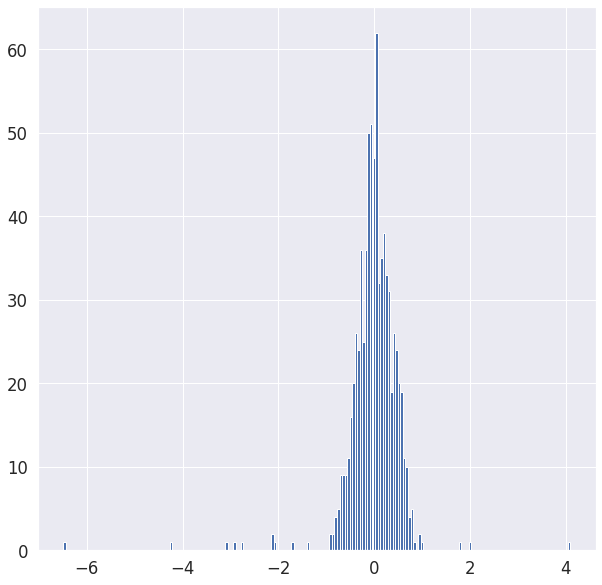

In [279]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [16]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

len(token_vecs)

226

In [17]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]
sentence_embedding_1 = np.mean(token_vecs, axis=0)
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

In [18]:
for i, token_str in enumerate(tokenized_text[2]):
    print(i, token_str)

0 [CLS]
1 why
2 do
3 people
4 who
5 do
6 not
7 know
8 what
9 a
10 particular
11 time
12 in
13 the
14 past
15 was
16 like
17 feel
18 the
19 need
20 to
21 try
22 to
23 define
24 that
25 time
26 for
27 others
28 ?
29 replace
30 woodstock
31 with
32 the
33 civil
34 war
35 and
36 the
37 apollo
38 moon
39 -
40 landing
41 with
42 the
43 titanic
44 sinking
45 and
46 you
47 '
48 ve
49 got
50 as
51 realistic
52 a
53 flick
54 as
55 this
56 formula
57 ##ic
58 soap
59 opera
60 populated
61 entirely
62 by
63 low
64 -
65 life
66 trash
67 .
68 is
69 this
70 what
71 kids
72 who
73 were
74 too
75 young
76 to
77 be
78 allowed
79 to
80 go
81 to
82 woodstock
83 and
84 who
85 failed
86 grade
87 school
88 composition
89 do
90 ?
91 "
92 i
93 '
94 ll
95 show
96 those
97 old
98 mean
99 ##ies
100 ,
101 i
102 '
103 ll
104 put
105 out
106 my
107 own
108 movie
109 and
110 prove
111 that
112 you
113 don
114 '
115 t
116 have
117 to
118 know
119 nut
120 ##tin
121 about
122 your
123 topic
124 to
125 still
126 make
127 

In [19]:
print('First 5 vector values for each instance of "like".')
print('')
print("look like   ", str(token_vecs[26][:25]))
print("like asleep  ", str(token_vecs[64][:25]))
print("like watching   ", str(token_vecs[82][:25]))

First 5 vector values for each instance of "like".

look like    [ 0.16747119  0.7391778   0.06014905  0.06633411  0.02639098  0.6185348
  0.48987526  0.40851593 -0.2084951  -0.71203136  0.6353633  -0.38782072
 -0.65521795  0.239177    0.32573342  0.6279339   0.5370582  -0.31530362
  0.54043543 -0.4394292  -0.5314656  -0.01198913 -0.09960466  0.28361288
  0.3106289 ]
like asleep   [-0.37601322  0.24610731  0.7848696   0.24214675  0.35558778  0.2772853
 -0.42375562  0.7303889   0.2974851  -0.1005075   0.8651125  -0.7820146
 -0.76253664  0.8403866  -0.3087556   0.86622465  0.81928635 -0.10913184
 -0.39470518  0.40988266  0.14856559  0.7462918   0.32057008  1.2573198
  0.2515132 ]
like watching    [ 1.0907935   0.5672793   0.00731068  0.04964197  0.07935197 -0.71956307
  0.17194863  1.0082768  -1.2261734   0.01281721  0.9519456  -0.3722507
 -0.3381405   0.54063046 -0.3036385   1.0028565   0.10563994 -0.30512074
  0.64354694 -0.38637576  0.6053909   0.00616048  0.38467333 -0.11766554
  0.5

In [20]:
from scipy.spatial.distance import cosine
diff_like = 1 - cosine(token_vecs[25], token_vecs[26])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_like = 1 - cosine(token_vecs[25], token_vecs[64])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_like)
print('Vector similarity for *different* meanings:  %.2f' % diff_like)

Vector similarity for  *similar*  meanings:  0.34
Vector similarity for *different* meanings:  0.49


In [21]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.03745698928833008

In [0]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

word_64 = word_vector(texts[2], 64, model_embedding, tokenizer)
word_26 = word_vector(texts[2], 26, model_embedding, tokenizer)
word_82 = word_vector(texts[2], 82, model_embedding, tokenizer)


In [0]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

sen_vec_0 = sentence_vector(texts[2], model_embedding, tokenizer)
sen_vec_1 = sentence_vector(texts[2], model_embedding, tokenizer, method="model")

In [29]:
from transformers import pipeline
nlp_sentiment = pipeline('sentiment-analysis')

In [37]:
df.text[1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

In [38]:
nlp_sentiment(df.text[1])

[{'label': 'NEGATIVE', 'score': 0.998344361782074}]

In [39]:
nlp_sentiment(df.text[3])

[{'label': 'NEGATIVE', 'score': 0.9997974634170532}]

In [40]:
df.text[3]

'Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.'

In [32]:
nlp_question = pipeline('question-answering')

In [43]:
nlp_question({
     'question': 'What is most important feature of this movie ?',
     'context': df.text[10]
 })

{'answer': 'Laural and Hardy.',
 'end': 85,
 'score': 0.40122689303472114,
 'start': 68}

In [34]:
nlp_feature = pipeline('feature-extraction')


In [0]:
vec = nlp_feature(df.text[10])

Output hidden; open in https://colab.research.google.com to view.

In [46]:
from transformers import AutoModelWithLMHead, AutoTokenizer
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [51]:
sequence = df.text[3]

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.

I have a few other movies I would like to see. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a man of God. I would like to see a movie about a man who is a ma

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [53]:

train_text.head()

38421    I never really started watching the show until...
39266    Legend of Zu is possibly the most exciting mov...
22527    In watching this off and on for a few seasons,...
11773    Mickey Rooney (as Mi Taylor) is a young man dr...
8667     Banned as a 'Video Nasty' in the UK, Unhinged ...
Name: text, dtype: object

In [0]:
train_text.to_frame().to_csv(r'train_text_review', header=None, index=None, sep=' ', mode='a')

In [0]:
test_text.to_frame().to_csv(r'test_text_review', header=None, index=None, sep=' ', mode='a')

In [0]:
import lucem_illud_2020

In [0]:
fake_news = "/content/drive/My Drive/Colab Notebooks/Fake.csv"

In [81]:
fake_news = pandas.read_csv(fake_news)
fake_news.head

<bound method NDFrame.head of                                                    title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                                                  ...  ...                ...
23476  McPain: John McCain Furious That Iran Treated ...  ...   January 16, 2016
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...   January 16, 2016
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...   January 15, 2016
23479  How to Blow $700 Million: Al Jazeera America F...  ...   January 14, 2016
23480  10 U.S. Navy Sailors Held by Iranian Military ...  ...   January 12, 201

In [88]:
texts = []
for each in fake_news['text']:
  texts.append(each)

print(" ".join(texts[:10]))

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [0]:
train_text, test_text = train_test_split(texts, test_size=0.2)
with open("news_train", 'w') as f:
    for item in train_text:
        f.write("%s\n" % item)
    
with open("news_test", 'w') as f:
    for item in test_text:
        f.write("%s\n" % item)

In [0]:

tokenizer_ = AutoTokenizer.from_pretrained("bert-base-uncased")
model_ = AutoModelWithLMHead.from_pretrained("bert-base-uncased")


In [132]:
sequence = "China is going to"

input = tokenizer_.encode(sequence, return_tensors="pt")
generated = model_.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_.decode(generated.tolist()[0])
print(resulting_string)

[CLS] china is going to [SEP] war. war. war. war.....................................


In [134]:
tokenizer_b = AutoTokenizer.from_pretrained("bert-large-uncased")
model_b = AutoModelWithLMHead.from_pretrained("bert-large-uncased")


In [138]:
sequence = "China is going to"

input = tokenizer_b.encode(sequence, return_tensors="pt")
generated = model_b.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_b.decode(generated.tolist()[0])
print(resulting_string)

[CLS] china is going to [SEP] and...........................................


In [0]:
from google.colab import files
#For the folder you have to zip it first and can only download later on

#Download files
files.download('bears.zip')
